# ДЗ №1. Броуновского движениe

В данном задании вы будете моделировать движение малых объектов в сплошной среде.

Выполнять на ядре версии `3.7`.

### Требования к сдаче задания

1. Дедлайн **4 марта в 23:59 по МСК**. После дедлайна работы не принимаются, кроме случаев наличия уважительной причины.
2. Сдача будет организована через google-форму.
3. У каждого студента будет свой **трёхзначный** уникальный номер (далее &mdash; `<ID>`).
4. Код генерации вместе с импортами должен быть рабочим и помещен в отдельный py-файл с именем `code_1_<ID>.py`, который надо загрузить в google-форму.
5. Также необходимо загрузить заполненный ноутбук как в формате `ipynb`, так и в формате `pdf`. В браузере можно `Print Page (Ctrl+P/Command+P) -> Save as PDF (без бэкграунда, хедера и футера)`. Имена должны быть `1_<ID>.ipynb` и `1_<ID>.pdf` соответственно.
6. Графики необходимо загружать в формате **`PNG`** в соответствии с комментариями к заданиям.
7. Для зачёта по заданиям блока `B` необходимо выполнить **все** задания блока `А`.

### Теория

Абсолютное значение скорости движения частиц идеального газа, находящегося в состоянии ТД-равновесия, есть случайная величина, имеющая распределение Максвелла и зависящая только от одного термодинамического параметра &mdash; температуры $T$.

В общем случае плотность вероятности распределения Максвелла для n-мерного пространства имеет вид:

$p(v) = \text{C}~\large e^{- \frac{mv^2}{2kT}} \normalsize v^{n-1}$,

где $v\in[0,+\infty)$, а константа $\text{C}$ находится из условия нормировки $\large\int\limits_0^{+\infty}\normalsize p(v)\mathrm dv=1$.

Физический смысл этой функции таков: вероятность того, что скорость частицы входит в промежуток $[v_0,v_0+\mathrm dv]$, приближённо равна $p(v_0)\mathrm dv$ при достаточно малом $\mathrm dv$. Тут надо оговориться, что математически корректное утверждение таково:

$\lim\limits_{\mathrm dv\to0}\large\frac{\mathbb P\{v|v\in[v_0,v_0+\mathrm dv]\}}{\mathrm dv}\normalsize=p(v_0)$.

Поскольку это распределение не ограничено справа, определённая доля частиц среды приобратает настолько высокие скорости, что при столкновении с макрообъектом может происходить заметное отклонение как траектории, так и скорости его движения.

Мы предполагаем идеальность газа, поэтому компоненты вектора скорости частиц среды $v_i$ можно считать независимыми нормально распределёнными случайными величинами, т.е.

$v_i\sim\mathrm{Norm}(0,s^2)$,

где $s$ зависит от температуры и массы частиц и одинаково для всех направлений движения.

При столкновении макрообъекта с частицами среды происходит перераспределение импульса в соответствии с законами сохранения энергии и импульса, но в силу большого числа подобных событий за единицу времени, моделировать их напрямую достаточно затруднительно. Поэтому для выполнения этого ноутбука сделаем следующие предположения:

- Приращение компоненты координаты броуновской частицы за фиксированный промежуток времени (или за шаг) $\Delta t$ имеет вид $\Delta x_i\sim\mathrm{Norm}(0,\sigma ^ 2)$.
- $\sigma$ является конкретным числом, зависящим как от $\Delta t$, так и от параметров броуновской частицы и среды.
- При этом $\sigma$ не зависит ни от координат, ни от текущего вектора скорости броуновкой частицы.

Если говорить формальным языком, в этом ноутбуке мы будем моделировать [Винеровский случайный процесс](https://ru.wikipedia.org/wiki/Винеровский_процесс) с фиксированным шагом.

In [1]:
import typing

from os import mkdir
from os.path import isdir, join as join_path
from functools import partial

import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D


np.random.seed(200)          # Для воспроизводимости результатов

DATA_DIR = 'homework_data/'  # Папка, куда мы будем сохранять все файлы
if not isdir(DATA_DIR):
    mkdir(DATA_DIR)

to_data_dir = partial(join_path, DATA_DIR)  # Склеивает путь к DATA_DIR с именем файла
print(f"Пример работы функции 'to_data_dir': {to_data_dir('test.file')}")

%matplotlib inline

Пример работы функции 'to_data_dir': homework_data/test.file


Любые другие библиотеки подключать запрещено, как и прописывать любые другие импорты.

### Задание

#### 1. Разработать функцию симуляции броуновского движения

Которая считает приращение координаты частицы на каждом шаге как $\Delta x_{ijk}\sim\mathrm{Norm}(0,\sigma^2)~\forall i,j,k$ (где $i$ &mdash; номер частицы, $j$ &mdash; номер координаты, а $k$ &mdash; номер шага) и принимает в качестве аргументов:
- Параметр $\sigma$;
- Количество последовательных изменений координат (шагов), приходящихся на один процесс;
- Число процессов для генерации (количество различных частиц);
- Количество пространственных измерений для генерации процесса.

Возвращаемое значение:
- 3-х мерный массив `result`, где `result[i,j,k]` &mdash; значение j-й координаты i-й частицы на k-м шаге.

##### Общие требования

- Функцию реализовать на основе черновика ниже (ничего из уже написанного не менять и не удалять).
- Считать, что все частицы в начальный момент времени находятся в начале координат.
- Пропущенные описания принимаемых аргументов дописать на русском.
- Если код будет не понятен проверяющему, оценка может быть снижена.

##### Требования блока `A`
- Реализовать функцию для двумерного броуновского движения, то есть только для `n_dims=2`.

##### Требования блока `B`
- Реализовать функцию для произвольной размерности, не используя циклы.
- Дописать проверки типов для остальных аргументов.

Обратите внимание на использование аннотаций для типов аргументов и возвращаемого значения функции. В новых версиях Питона подобные возможности синтаксиса используются в качестве подсказок для программистов и статических анализаторов кода, и никакой дополнительной функциональности не добавляют.

Например, `typing.Union[int, float]` означает `"или int, или float"`.

##### Что может оказаться полезным
- Генерация нормальной выборки: `scipy.stats.norm`. [Ссылка](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)
- Кумулятивная сумма: метод `cumsum` у `np.ndarray`. [Ссылка](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.cumsum.html)

In [2]:
def generate_brownian(sigma: typing.Union[int, float, complex] = 1,
                      *,
                      n_proc: int = 10,
                      n_dims: int = 2,
                      n_steps: int = 100) -> np.ndarray:
    """
    :param sigma:    стандартное отклонение нормального распределения,
                     генерирующего пошаговые смещения координат
                     
    :param n_proc:   число процессов для генерации (количество различных частиц)
    
    :param n_dims:   количество пространственных измерений для генерации процесса
    
    :param n_steps:  количество последовательных изменений координат (шагов), приходящихся на один процесс

    :return:         np.ndarray размера (n_proc, n_dims, n_steps), содеражащий на позиции
                     [i,j,k] значение j-й координаты i-й частицы на k-м шаге.
    """
    if not np.issubdtype(type(sigma), np.number):
        raise TypeError("Параметр 'sigma' должен быть числом")
    # Для кандидатов в отличники: <ДОПИСАТЬ ПРОВЕРКИ ТИПОВ>
    
    for par in [n_proc, n_dims, n_steps]:  # проверка типов данных
        if not np.issubdtype(type(par), np.number):
            raise TypeError("Параметр '{}' должен быть числом".format(par))
    
    result = np.random.normal(0, sigma**2, (n_proc, n_dims, n_steps - 1))  # генерируем случайные приращения координат
    result = np.concatenate([result, np.zeros((n_proc, n_dims, 1))], axis=2)  # начальные координаты - нули
    result = np.cumsum(result, axis=2)  # считаем координаты частиц на каждом шаге

    return result

Символ `*` в заголовке означает, что все аргументы, объявленные после него, необходимо определять только по имени.

Например,

```python
generate_brownian(323, 3)          # Ошибка
generate_brownian(323, n_steps=3)  # OK
```

При проверке типов остальных аргументов, по аналогии с `np.number`, можно использовать `np.integer`. Вы можете задаться вопросом, почему мы используем конструкцию `np.issubdtype(type(param), np.number)`? А всё потому что стандартная питоновская проверка `isinstance(sigma, (int, float))` не будет работать для нампаевских чисел `int64, int32, float64` и т.д.

In [3]:
brownian_2d = generate_brownian(2, n_steps=12000, n_proc=500, n_dims=2)
brownian_3d = generate_brownian(2, n_steps=12000, n_proc=500, n_dims=3)
assert brownian_2d.shape == (500, 2, 12000)

#### 2. Отобразить траектории для 9-ти первых броуновских частиц

##### Требования блока `A`
- Реализовать 2D-графики для `brownian_2d`. Загрузить в форму с именем `1_<ID>_1.png`.

##### Требования блока `B`
- Реализовать 3D-графики для `brownian_3d = generate_brownian(2, n_steps=12000, n_proc=500, n_dims=3)`. Загрузить в форму с именем `1_<ID>_2.png`.

##### Общие требования
- Установить соотношение масштабов осей, равное 1, для каждого из подграфиков.

##### Что может оказаться полезным
- [Туториал](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html) по построению нескольких графиков на одной странице.
- Метод `plot` у `AxesSubplot` (переменная `ax` в цикле ниже).
- Метод `set_aspect` у `AxesSubplot`.

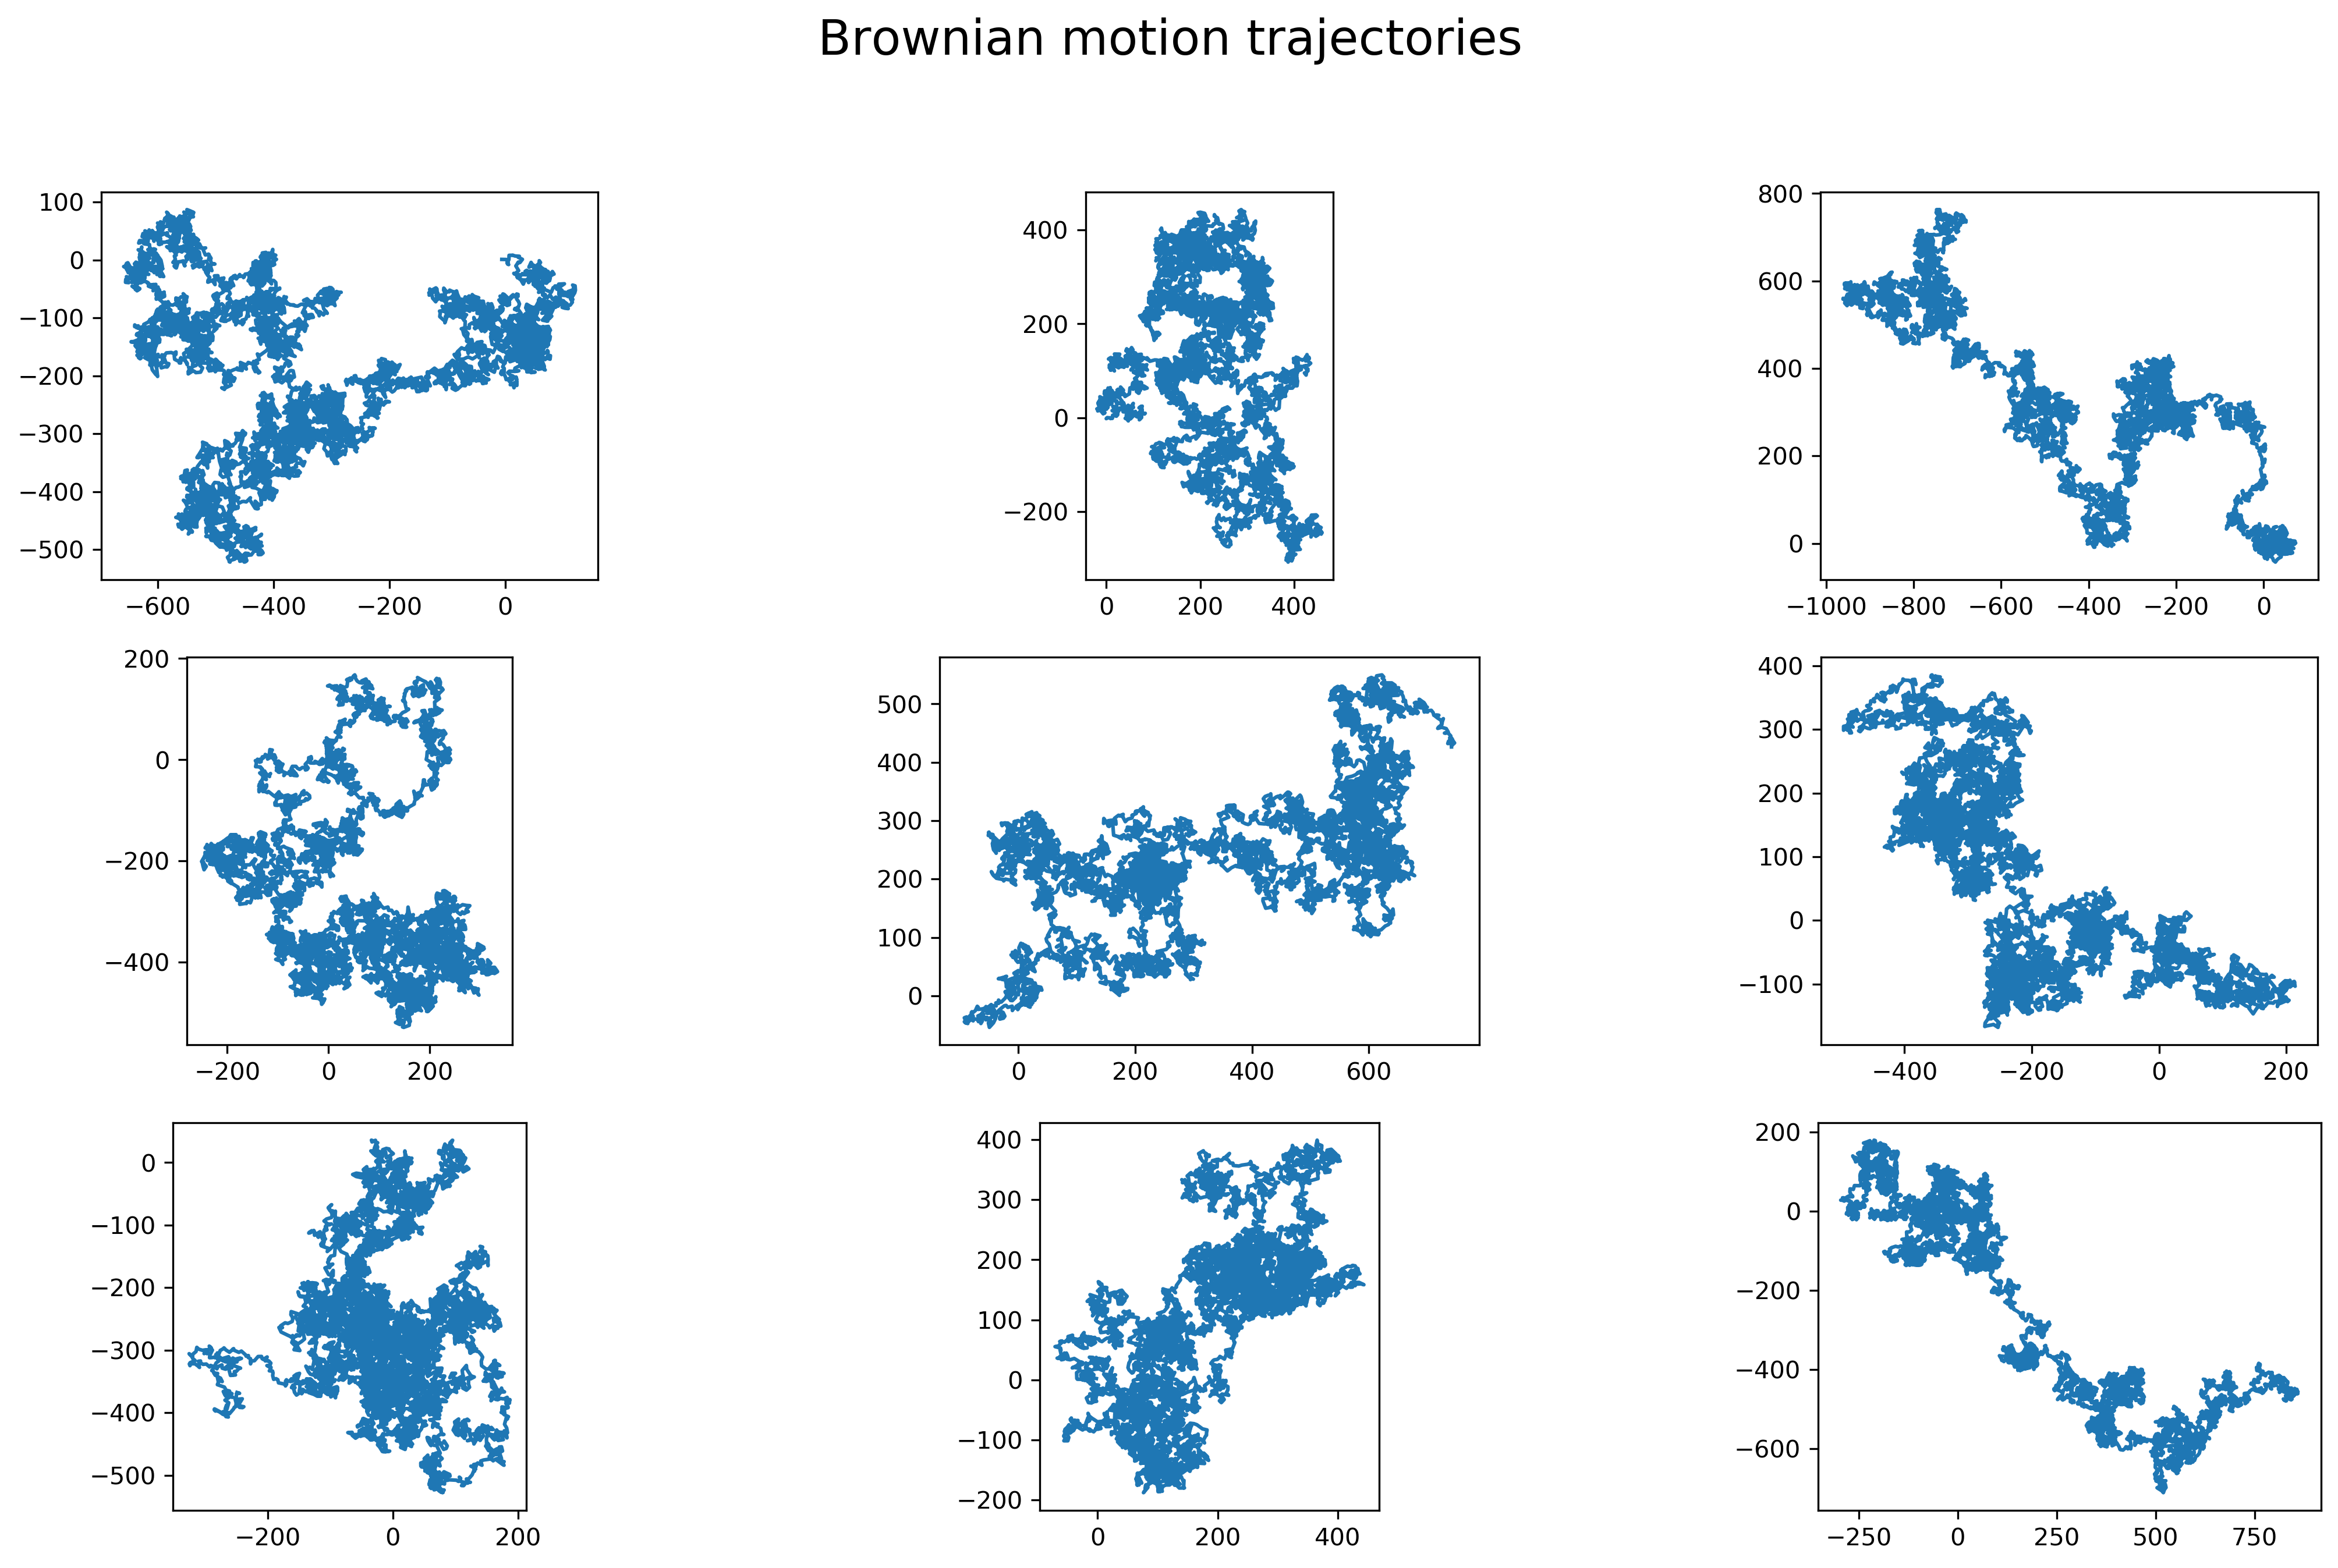

In [4]:
# Для блока А
fig, axes = plt.subplots(3, 3, figsize=(18, 10), dpi=300)
fig.suptitle('Brownian motion trajectories', fontsize=20)

for ax, (xs, ys) in zip(axes.flat, brownian_2d):
    # Place your code here
    ax.set_aspect(1)
    ax.plot(xs, ys)
plt.savefig(to_data_dir('brownian_motion.png'))

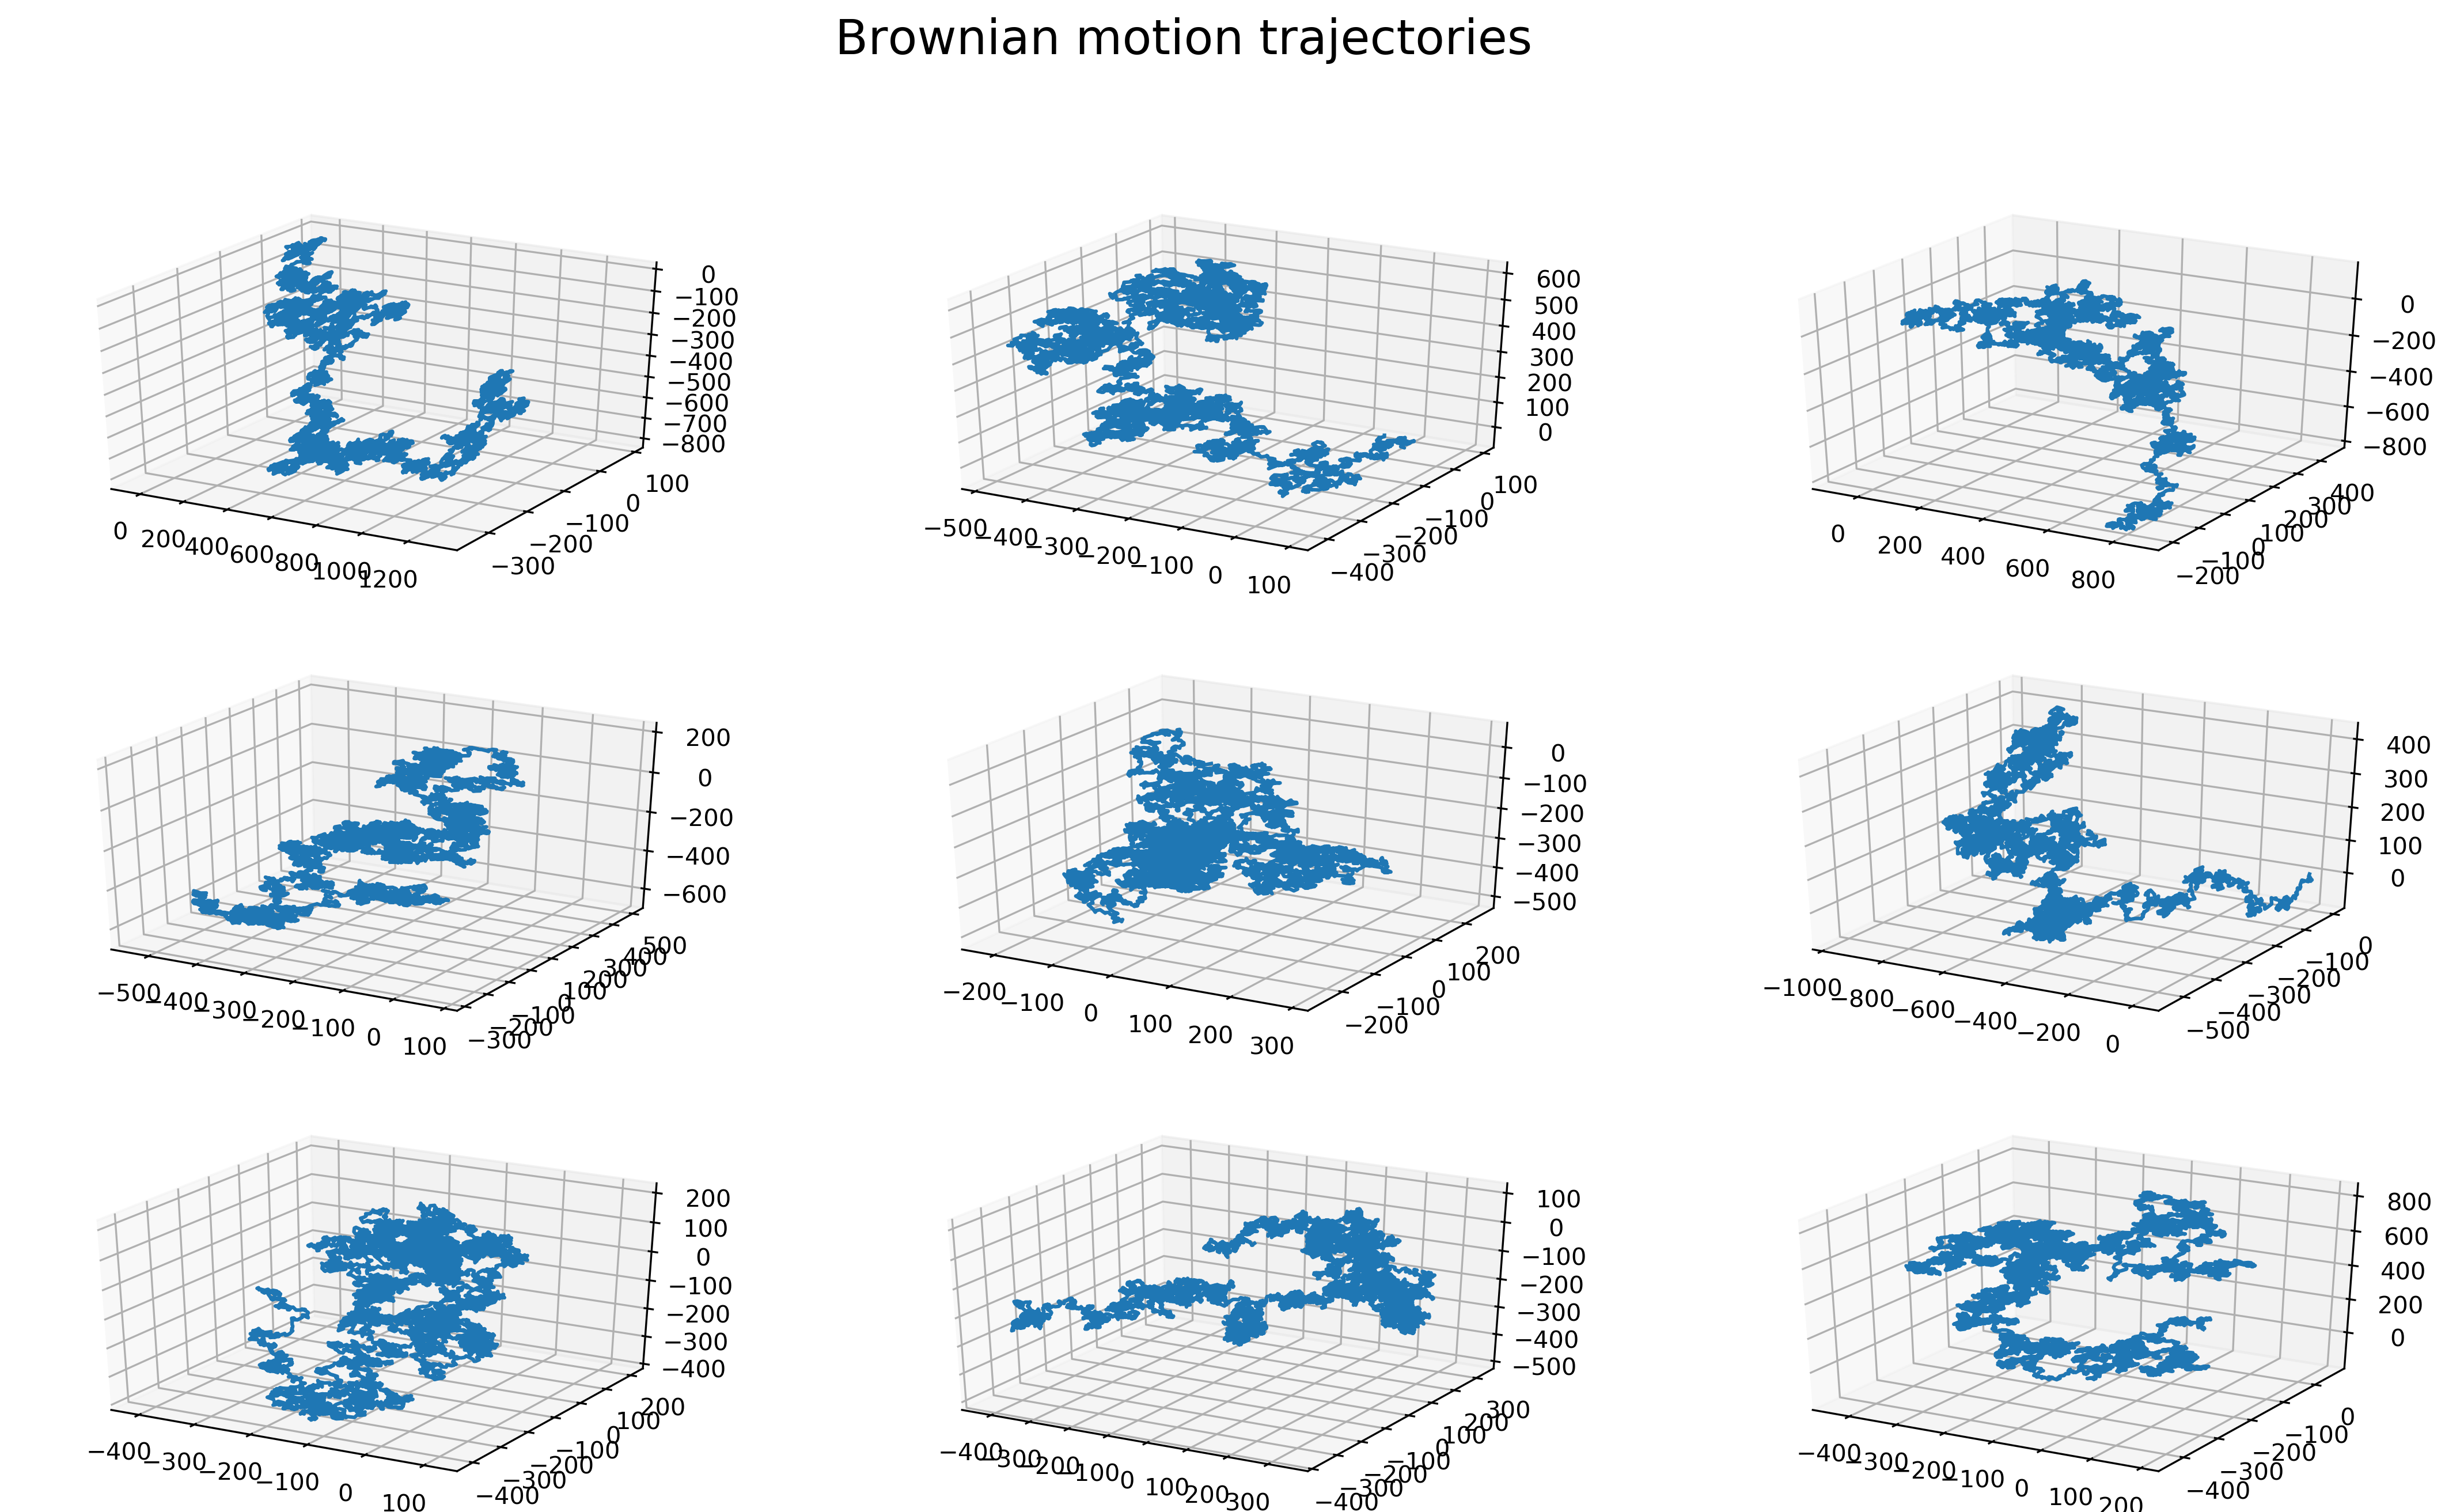

In [5]:
# Блок B
fig = plt.figure(figsize=(18, 10), dpi=300)
fig.suptitle('Brownian motion trajectories', fontsize=20)

for i, (xs, ys, zs) in zip(range(1, 10), brownian_3d):
    # Place your code here
    ax = fig.add_subplot(3, 3, i, projection='3d')
    ax.plot(xs, ys, zs)
plt.savefig(to_data_dir('brownian_motion_3d.png'))

#### 3 [Только для блока `B`]. Построить график среднего расстояния частицы от начала координат в зависимости от времени (шага)

- Реализовать для `n_dims` от 1 до 5 включительно.
- Кривые должны быть отрисованы на одном графике. Каждая кривая должна иметь легенду.
- Для графиков подписи к осям обязательны.
- Загрузить в форму с именем `1_<ID>_3.png`.

##### Дополнительные вопросы
- Как вы думаете, какой функцией может описываться данная зависимость?
- Сильно ли её вид зависит от размерности пространства?
- Можно ли её линеаризовать? Если да, нарисуйте график с такими же требованиями и загрузите его в форму с именем `1_<ID>_4.png`.

# Дополнительные вопросы

* Зависимость описывается законом <<$\sqrt{N}$>>
* $\textbf{Вид}$ зависимости не зависит от размерности пространства, он все время $\sqrt{N}$
* Линейна в координатах $y^2 - N$

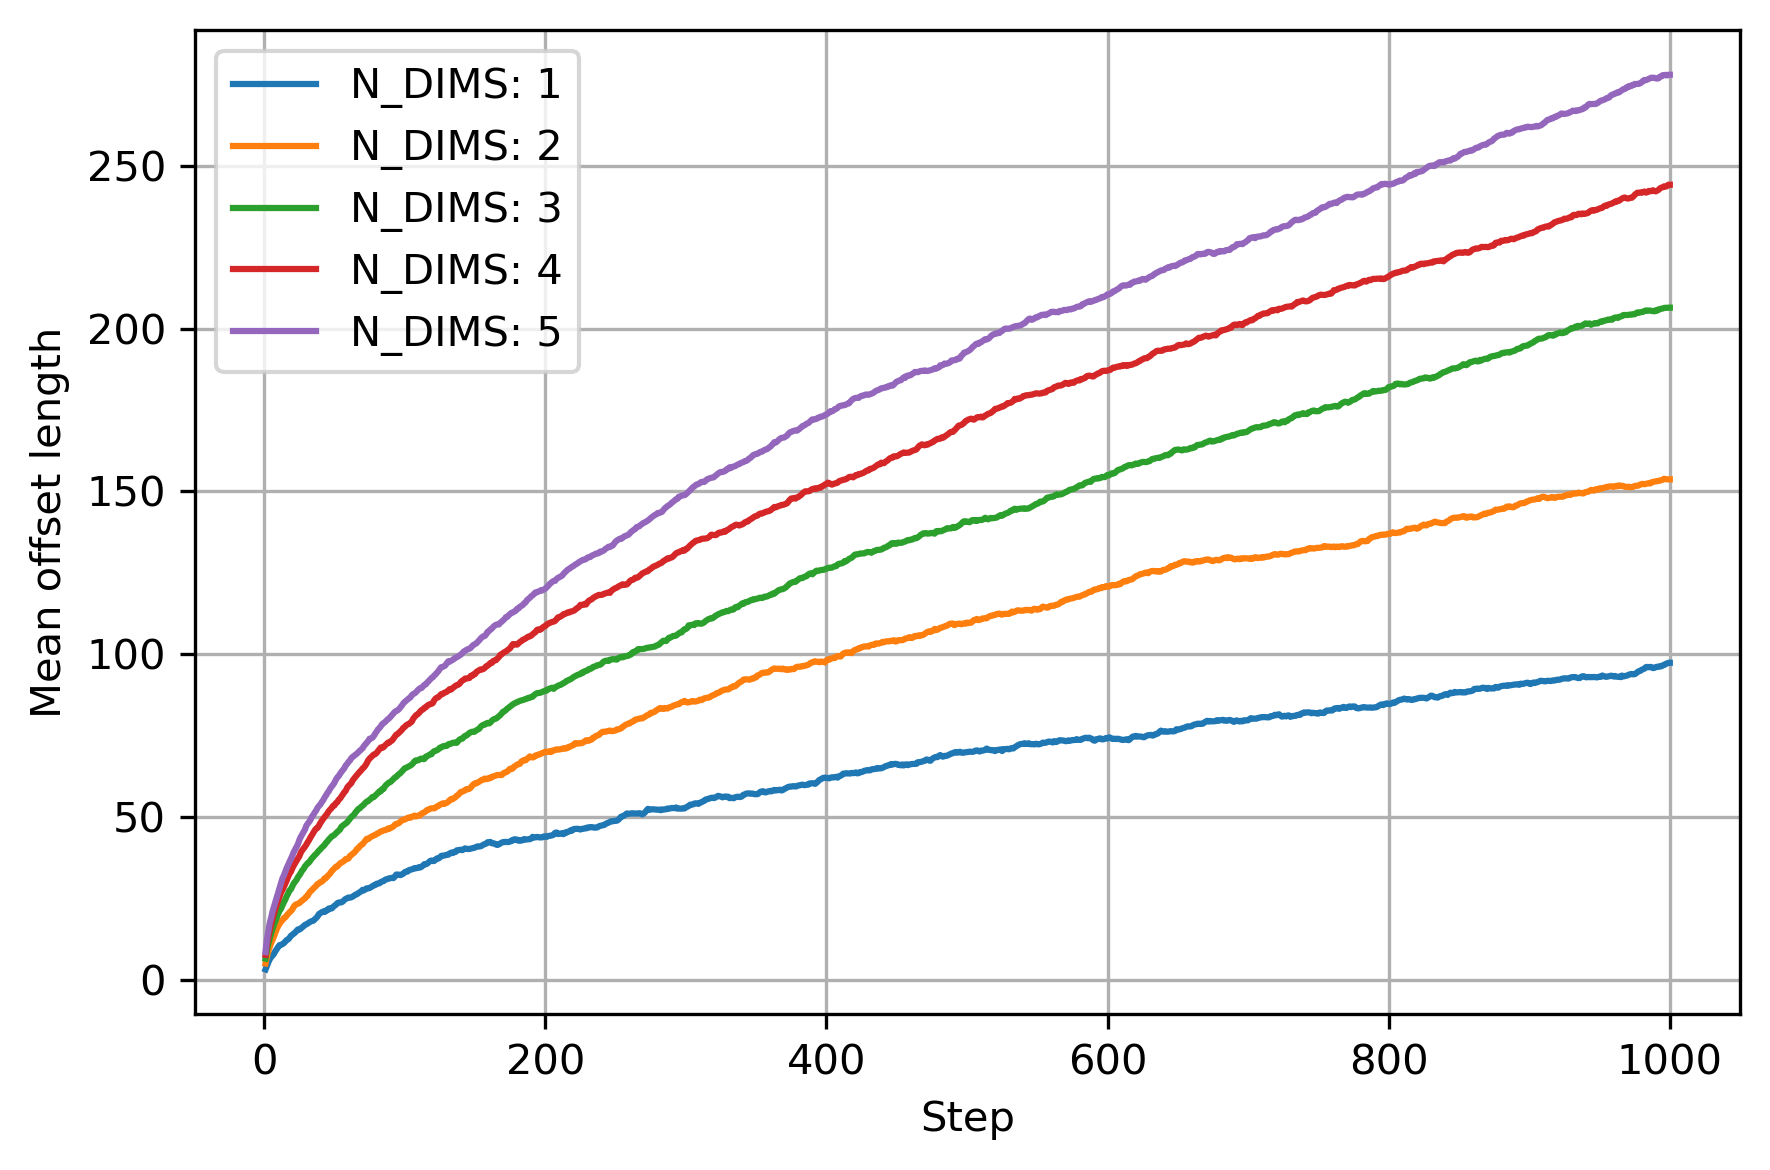

In [6]:
def mean_distance(n_dims):
    """
    :param: n_dims:    размерность пространства
    
    :return:           np.ndarray размера n_proc
    """
    brownian = generate_brownian(2, n_steps=1000, n_proc=500, n_dims=n_dims)  # броуновское движение, размерность n_dim
    means = np.zeros((brownian.shape[0], brownian.shape[2]))
    
    for k in range(brownian.shape[2]):  # итерация по номеру шага
        for i in range(brownian.shape[0]):  # итерация по номеру частицы
            means[i, k] = np.linalg.norm(brownian[i, :, k])  # вычисляем расстояние до начала координат для каждой частицы
    
    means = np.mean(means, axis=0)  # усредняем значения по частицам
    return means


plt.figure(dpi=300)

for n_dims in range(1, 6):
    y = mean_distance(n_dims)
    plt.plot(
        # Place your code here
        range(1, len(y) + 1),
        y,
        label=f'N_DIMS: {n_dims}'
    )

plt.ylabel('Mean offset length')
plt.xlabel('Step')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.savefig(to_data_dir('brownian_lengths.png'))

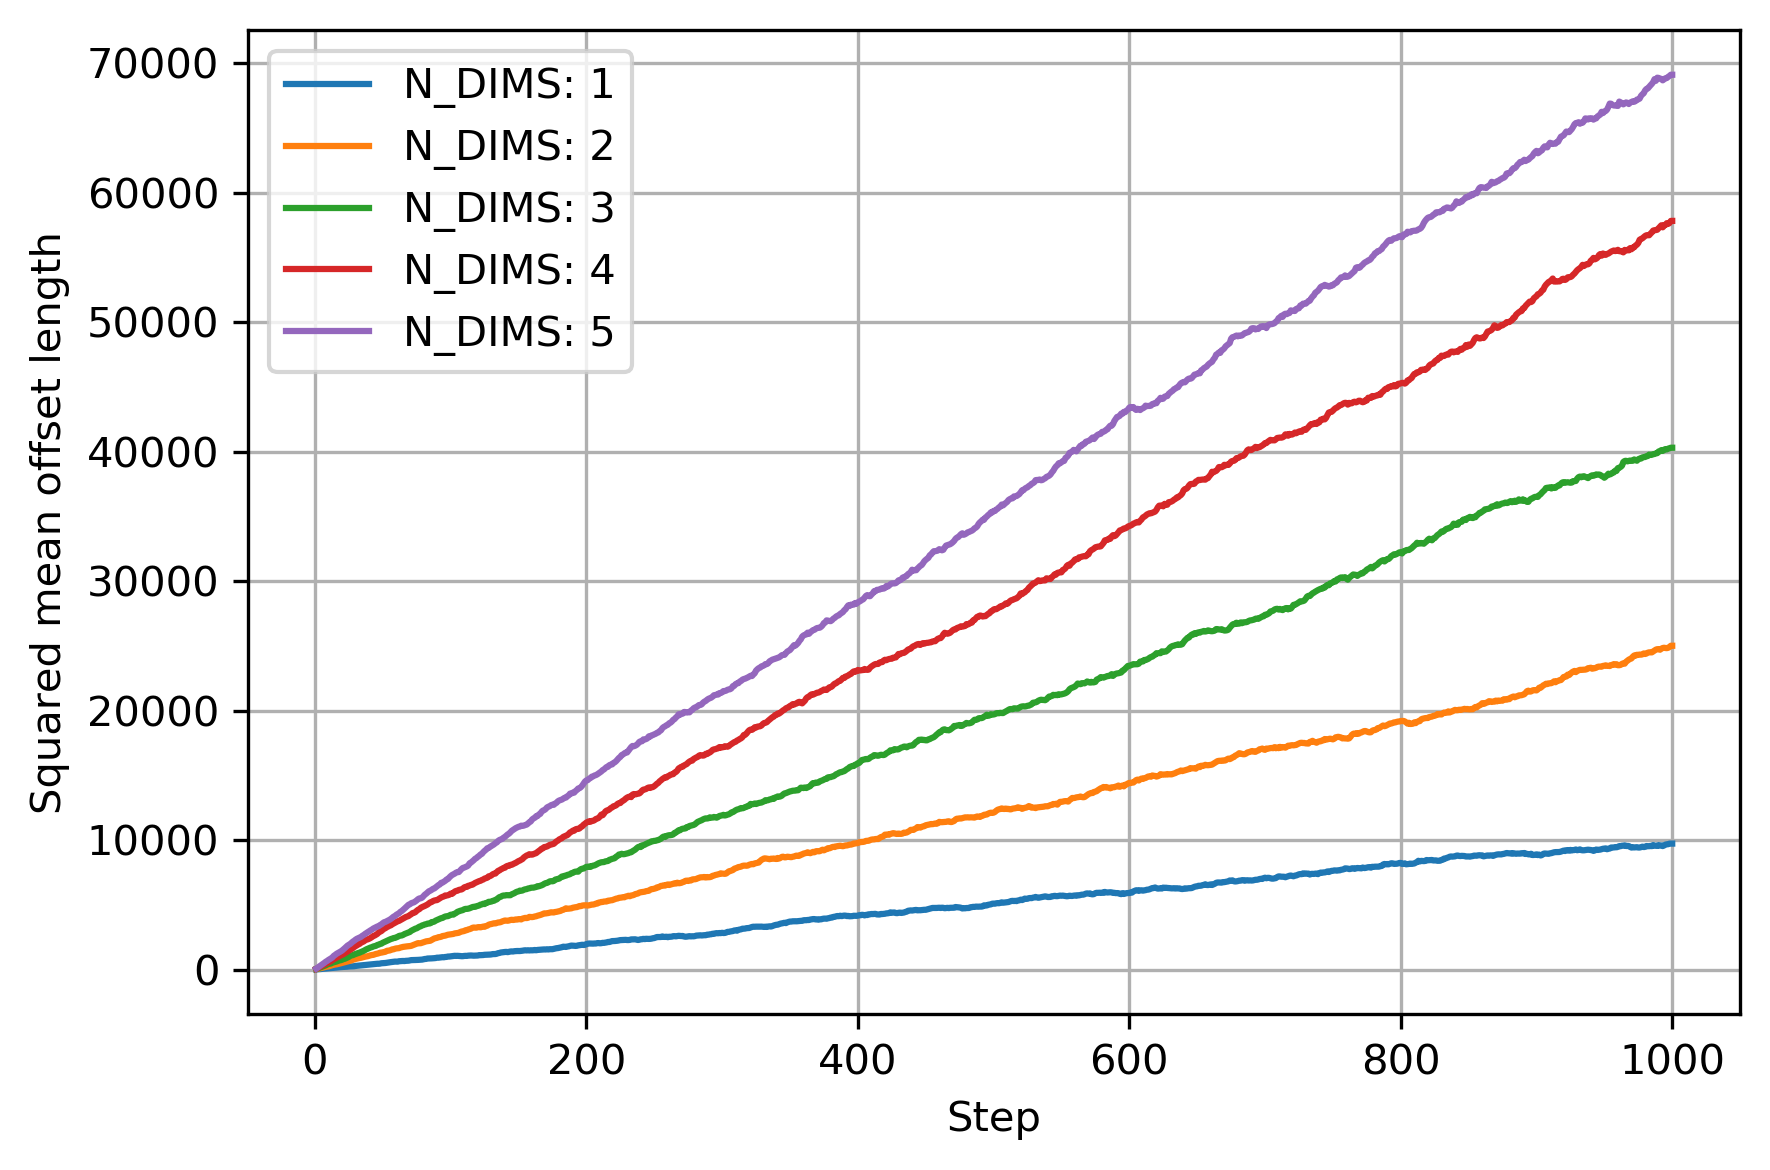

In [7]:
plt.figure(dpi=300)

for n_dims in range(1, 6):
    y = mean_distance(n_dims)**2
    plt.plot(
        # Place your code here
        range(1, len(y) + 1),
        y,
        label=f'N_DIMS: {n_dims}'
    )

plt.ylabel('Squared mean offset length')
plt.xlabel('Step')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.savefig(to_data_dir('brownian_lengths_1.png'))

<div style="text-align: right"><i>Подготовил <a href="https://github.com/andrewsonin">Андрей Сонин</a>